# Classification

In this unit, we will look at building models which involve *classifying* data; each set of data points fit into one of a number of categories (e.g.: kind of fruit, win/loss, home country, etc.), and once the model has been trained, it will predict what category new sets of data will fit into.  The three main modelling techniques we will be reviewing are logistic regression, decision trees, and naive Bayes classification.  

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy import stats, special
from sklearn import model_selection, metrics, linear_model, datasets, feature_selection
from seaborn import pairplot, heatmap

import matplotlib.pyplot as plt
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# The basic `sklearn` programming pattern for building a classifier

In this lesson we will learn to apply a number of different machine learning algorithms, all through the package `sklearn`. The basic pattern for building these models is the same regardless of the model.

1. Construct a 1-dimensional vector (i.e a column) containing the outcomes that we are trying to predict. By convention, we will usually call this vector `y`, and that's what `sklearn` calls it.
2. Construct a matrix of _features_. This matrix should have the same number of rows as `y`, and each column of this matrix is a _feature_ that we expect to help us predict `y`.
3. Initialize a model object. For example, imagine there was a type of model model called a SFU Regression, which was implemented in `sklearn` as `SFURegression`. The `sklearn` pattern would have us create an object `SFUreg = Regression()`.
4. _Train_ (or "fit", using the `sklearn` lingo) the model object created in the last step using the `fit()` method, and the datasets `y` and `X`: `SFUreg.fit(X, y)`.

Once we have a fitted model object, we can use it to make predictions. Given a matrix `Xnew` with the same number of columns as `X`, we can call `SFUreg.predict(Xnew)` to obtain predicted values given the features in `Xnew`. Model objects have a number of other methods and attributes that vary by the type of model.

Let's try it out.

# Binary Classification

The most basic form of classification problem is the problem of _binary classification_. Binary classification is the problem of predicting what class a unit will fall into when there are only two classes. This is particularly useful since any question that can be posed in yes-or-no form can be modeled as a binary classification problem:

- Is the tumor benign or malignant?
- Will the customer make a purchase?
- Does this image contain a face?
- Will the price of this stock go up?

For convenience, it is typical to think of one of the labels as being a "positive" outcome, and the other as the "negative" or "null" outcome. We will usually encode this numerically by using $1$ for the positive outcome, and $0$ for the negative outcome.

Let's load up some data for a binary classification.

In [2]:
cd Downloads

[WinError 2] The system cannot find the file specified: 'Downloads'
C:\Users\abuel\Downloads


C:\Users\abuel\anaconda3\Lib\site-packages\IPython\core\magics\osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [3]:
bt = pd.read_csv('blood_transfusions.csv')  # Yeh, I-Cheng, Yang, King-Jang, and Ting, Tao-Ming, "Knowledge discovery on RFM model using Bernoulli sequence, "Expert Systems with Applications, 2008
bt.head()

,Recency,Frequency,Monetary,Time,Donated
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


This dataset is taken from the [UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/Blood+Transfusion+Service+Center), which provides the following description of the fields.

> Data Set Information:

> To demonstrate the RFMTC marketing model (a modified version of RFM), this study
adopted the donor database of Blood Transfusion Service Center in Hsin-Chu City
in Taiwan. The center passes their blood transfusion service bus to one
university in Hsin-Chu City to gather blood donated about every three months. To
build a FRMTC model, we selected 748 donors at random from the donor database.
These 748 donor data, each one included R (Recency - months since last
donation), F (Frequency - total number of donation), M (Monetary - total blood
donated in c.c.), T (Time - months since first donation), and a binary variable
representing whether he/she donated blood in March 2007 (1 stand for donating
blood; 0 stands for not donating blood).

The problem is to predict whether a person ended up donating blood in March 2007 based on information about their previous donation habits.

**What do you think the authors wanted to use this model for? What _could_ it be used for?**

This is a binary classification problem because a person either donates (1) or doesn't (0). Let's have a look at the dataset.

In [ ]:
bt.describe()

,Recency,Frequency,Monetary,Time,Donated
count,748.000000,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086,0.237968
std,8.095396,5.839307,1459.826781,24.376714,0.426124
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.750000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,50.000000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


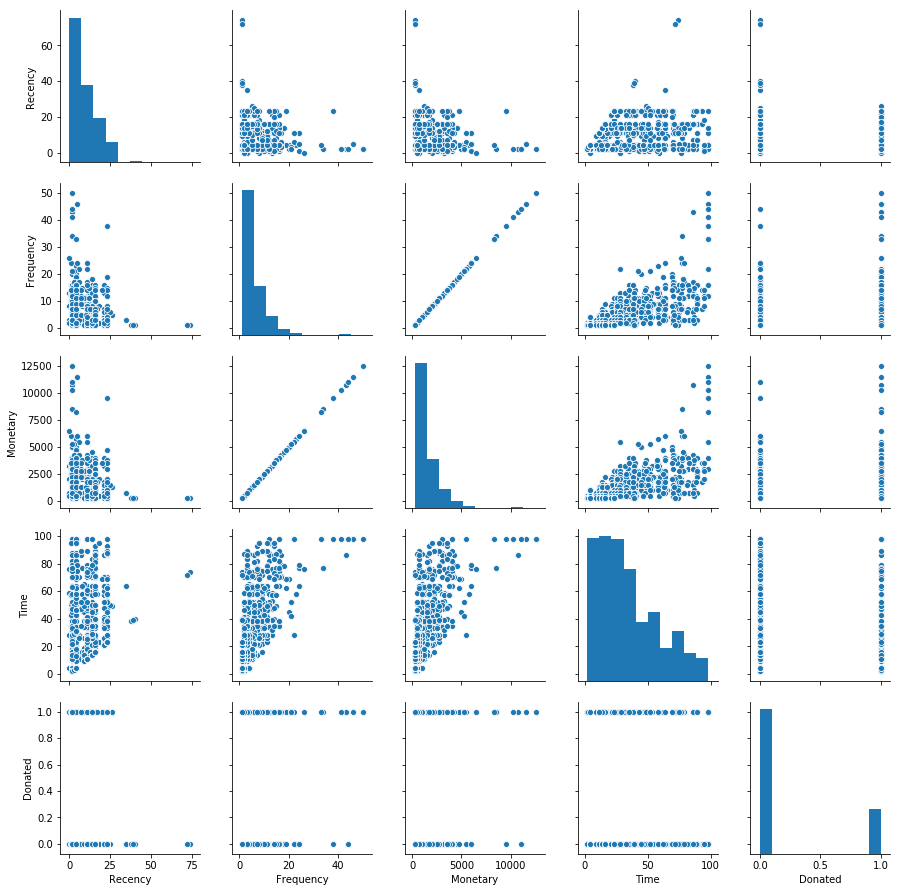

In [ ]:
pairplot(bt)

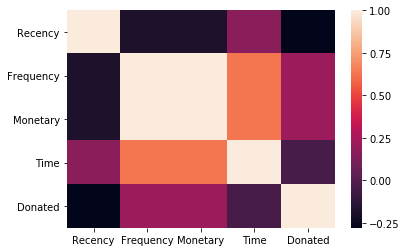

In [ ]:
heatmap(bt.corr())

**What do these plots tell us about the data?**

## Logistic Regression

Logistic regression is a way of modeling the probability of the positive outcome. Viewed in this way, it can actually be thought of as a _regression_ and not a _classification_ method (hence the name). However, the output of a logistic regression can be easily viewed as a classifier by setting some threshold $t$, and whenever the positive outcome has probability greater than $t$, we classify it appropriately.

Using this method for the blood donor data and with $t=0.5$, we will classify a person as a "likely donor" if their probability of donating is greater than $0.5$.

Logistic regression works by fitting what's called a **logit function** to the data.

In [4]:
x = np.arange(-7,7,0.01)
plt.plot(x,special.expit(x));
plt.grid()
plt.xlim(-7,7)

(-7.0, 7.0)

As $x\to -\infty$, the function asymptotically approaches $0$, and as $x\to+\infty$, the function asymptotically approaches $1$.  This will help us split our categorical results into $0$ and $1$; we accomplish this by trying to find the parameters $\beta_0,\beta_1$ such that our dependent variable $y$ has the form:

$$ y = \begin{cases} 1,\,\text{ if }\,\beta_0+\beta_1x + \epsilon > 0 \\ 0,\,\text{  otherwise  }\end{cases} $$

We feed this equation of the line into the logistic function; by transforming the function, we can essentially create a boundary along $x$ whereby for some given $c$, if $x<c$ then the result is 0, and if $x>c$ the result is 1 (or vice versa).  The logistic function takes on the form:

$$ \sigma(x) = \frac{1}{1+ e^{-(\beta_0 + \beta_1x + \epsilon)}} $$


As a somewhat extreme example, the transformation to

$$  \sigma(x) = \frac{1}{1+e^{20x-12}} $$
looks like:

In [5]:
plt.plot(x,special.expit(20*x -12))
plt.grid()
plt.xlim(-7,7);

### Applying Logistic Regression

Let's apply this to the blood transfusion data. We'll start by considering whether the donor donates as a function of their donation frequency.

In [6]:
X = bt['Frequency'].values.reshape(-1,1)  ## Annoying hack you have to do when you have one independent variable
y = bt['Donated']

In [7]:
bt_model = linear_model.LogisticRegression(solver='liblinear')
bt_model.fit(X, y)

LogisticRegression(solver='liblinear')

The fitted logistic regression object can make predictions given new frequency observations with the `.fit` method.

In [8]:
Xnew = np.arange(1,30).reshape(-1,1)
bt_model.predict(Xnew)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

We can see the coefficients that were fit by accessing the `intercept_` and `.coef_` attributes of the fitted model.

In [10]:
beta_0 = bt_model.intercept_[0]
print(beta_0)
beta_1 = bt_model.coef_[0][0]
print(beta_1)

-1.6115249184592333
0.07709726512074265


So this model estimates that the probability that a donor will give, conditional on their giving frequency being $x$, as:

$$
P(\text{Give}|\text{Frequency}=x) = \frac{1}{1 + e^{-\left(0.0770972651207 -1.61152491846 x \right)}}
$$

We could use this to create a function that estimates the probability of giving, given a past frequency `x`.

In [11]:
def predict_probability(x):
    return 1/(1 + exp(-(beta_0 + beta_1 * x)))
[predict_probability(x) for x in Xnew]

[array([0.17734679]),
 array([0.18887597]),
 array([0.20097156]),
 array([0.21363773]),
 array([0.22687552]),
 array([0.24068251]),
 array([0.25505255]),
 array([0.26997552]),
 array([0.28543706]),
 array([0.30141848]),
 array([0.31789662]),
 array([0.3348438]),
 array([0.35222791]),
 array([0.3700125]),
 array([0.38815697]),
 array([0.40661692]),
 array([0.42534447]),
 array([0.44428875]),
 array([0.46339638]),
 array([0.48261211]),
 array([0.5018794]),
 array([0.52114112]),
 array([0.54034017]),
 array([0.55942023]),
 array([0.57832636]),
 array([0.59700564]),
 array([0.61540772]),
 array([0.63348538]),
 array([0.65119492])]

Thankfully, we don't have to define this function each time we want to estimate probabilities. The LogisticRegression object has a method for that built in.

In [12]:
bt_model.predict_proba(Xnew)

array([[0.82265321, 0.17734679],
       [0.81112403, 0.18887597],
       [0.79902844, 0.20097156],
       [0.78636227, 0.21363773],
       [0.77312448, 0.22687552],
       [0.75931749, 0.24068251],
       [0.74494745, 0.25505255],
       [0.73002448, 0.26997552],
       [0.71456294, 0.28543706],
       [0.69858152, 0.30141848],
       [0.68210338, 0.31789662],
       [0.6651562 , 0.3348438 ],
       [0.64777209, 0.35222791],
       [0.6299875 , 0.3700125 ],
       [0.61184303, 0.38815697],
       [0.59338308, 0.40661692],
       [0.57465553, 0.42534447],
       [0.55571125, 0.44428875],
       [0.53660362, 0.46339638],
       [0.51738789, 0.48261211],
       [0.4981206 , 0.5018794 ],
       [0.47885888, 0.52114112],
       [0.45965983, 0.54034017],
       [0.44057977, 0.55942023],
       [0.42167364, 0.57832636],
       [0.40299436, 0.59700564],
       [0.38459228, 0.61540772],
       [0.36651462, 0.63348538],
       [0.34880508, 0.65119492]])

The `predict_proba` method returns two probabilities for each `X`: the probability of 0, and of 1. Usually we only care about the probability of the 1 outcome, which we can get by slicing.

In [ ]:
bt_model.predict_proba(Xnew)[:,1]

array([0.17734679, 0.18887597, 0.20097156, 0.21363773, 0.22687552,
       0.24068251, 0.25505255, 0.26997552, 0.28543706, 0.30141848,
       0.31789662, 0.3348438 , 0.35222791, 0.3700125 , 0.38815697,
       0.40661692, 0.42534447, 0.44428875, 0.46339638, 0.48261211,
       0.5018794 , 0.52114112, 0.54034017, 0.55942023, 0.57832636,
       0.59700564, 0.61540772, 0.63348538, 0.65119492])

Let's use this to plot the probability of donation as a function of frequency, along with the actual values.

In [13]:
bt_data = bt[['Frequency', 'Donated']]
bt_data.plot.scatter("Frequency", "Donated")

# plot the predicted probability:
plt.plot(np.arange(0,50, .5), bt_model.predict_proba(np.arange(0,50,.5).reshape(-1,1))[:,1], color = 'red')

The `LogisticRegression` object also has a `.score()` method that takes a feature matrix and a vector of outcomes, makes predictions using the feature matrix, and checks those predictions against the actual values in `y`. It returns the proportion of predictions that would have been correct, which is known as the `accuracy`. We will talk a lot more about this next week, but let's use that here to see what the accuracy of this model would be on the training data.

In [14]:
bt_model.score(X,y)

0.766042780748663

Since this

**Problems & Questions**
1. Find the point where the probability is 0.5.
2. What do you think would happen to the model if you changed the threshold? For instance, what if instead of predicting positive when the probability is over 0.5, what if it predicted positive when the probability is over 0.6? 0.9?

### Logistic Regression with Multiple Features

The two examples we saw only had a single feature.  Logistic regression can be extended to multi-dimensional features in much the same way that linear regression can. Sci-kit learn makes this as easy as simply including more columns in the `X` variable. Let's try extending the blood transfusion model to two predictors: the frequency with which the donor donates, and the time since the last donation.

Let's look at scatter plots of these again.

In [15]:
bt.plot.scatter('Frequency', 'Donated')

<Axes: xlabel='Frequency', ylabel='Donated'>

In [16]:
bt.plot.scatter('Time', 'Donated')

<Axes: xlabel='Time', ylabel='Donated'>

How do you expect the model to fit to each of these, based on the plot?

In [17]:
X2 = bt[['Frequency', 'Time']]  # no need to do the .reshape hack this time, as we have more than one independent variable

bt_log_model_2 = linear_model.LogisticRegression(solver='liblinear')
bt_log_model_2.fit(X2,y)

LogisticRegression(solver='liblinear')

When we look at the coefficient, we get two values:

In [18]:
frequency_coef = bt_log_model_2.coef_[0][0]
frequency_coef

np.float64(0.1870485742139922)

In [19]:
time_coef = bt_log_model_2.coef_[0][1]
time_coef

np.float64(-0.036692239135777356)

In [20]:
bt_intercept = bt_log_model_2.intercept_[0]
bt_intercept

np.float64(-1.0453714960913807)

So our new model is

$$
P(\text{Give}|\text{Frequency}=x, \text{Time}=z) = \frac{1}{1 + e^{-\left(-1.0453714960913827 + 0.18704857421399171 x - 0.036692239135777224 z  \right)}}
$$

In [21]:
import mpl_toolkits.mplot3d as m3d

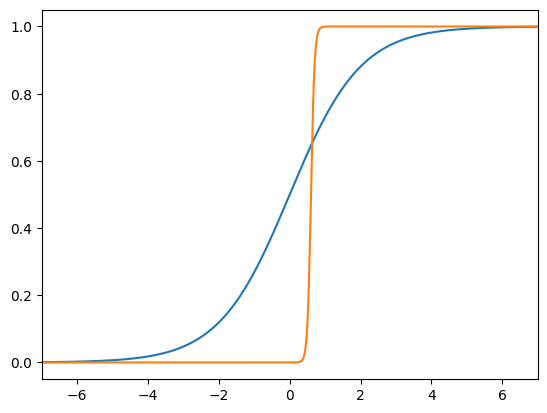

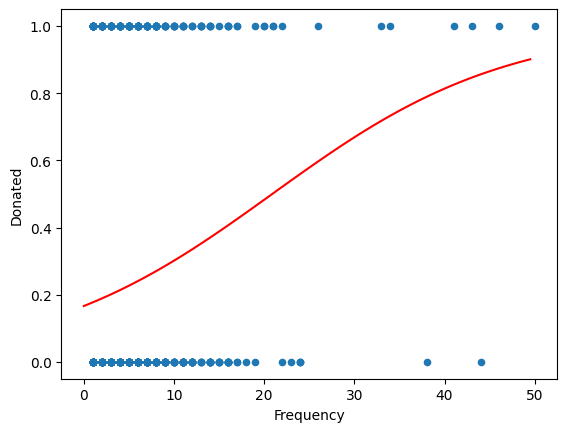

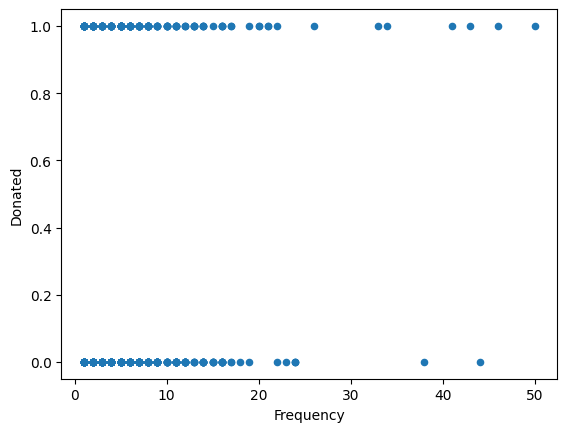

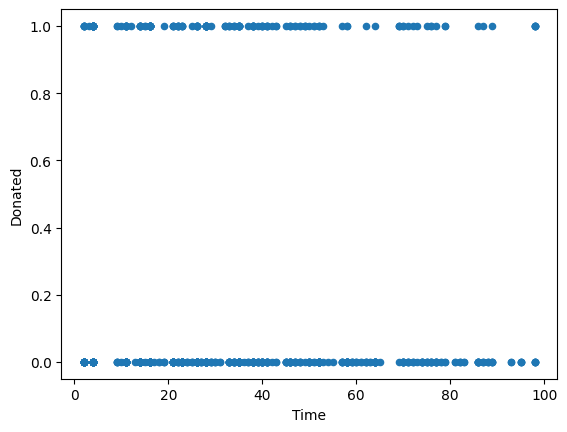

<Figure size 640x480 with 0 Axes>

In [22]:
freq = np.arange(0,50,.4)
time = np.arange(0,100,.8)
xx, yy = np.meshgrid(freq, time)
Z = 1/(1 + exp(-(bt_intercept + frequency_coef*xx + time_coef*yy)))
fig3d = m3d.Axes3D(plt.figure())
fig3d.plot_wireframe(xx, yy, Z, rstride=10, cstride=10);
fig3d.set_ylabel('Months since last donation')
fig3d.set_zlabel('Estimated Probability of Donation')
fig3d.view_init(12, 225)
fig3d.scatter3D(xs=bt['Frequency'], ys=bt['Time'], zs=bt['Donated'], color = 'green')
plt.show();

**Problem** Build a logistic regression model called `bt_log_model_3` which uses all of the features except for `Monetary` (why are we omitting that one?). Report the training accuracy.

In [23]:
#We don't need to include Monetary because it is always equal to Frequency * 250.
#The model is already using the frequency so
# including Monetary wouldn't give it any additional information.
X3 = bt[['Frequency', 'Time', 'Recency']]

bt_log_model_3 = linear_model.LogisticRegression(solver='liblinear')
bt_log_model_3.fit(X3,y)
bt_log_model_3.score(X3,y)

0.7700534759358288

### A note on the training accuracy

We've been using `model.score(X,y)` to get the training accuracy and using this as a proxy for the goodness of fit for the model. This is actually typically a problematic thing to do as we only testing what is given. The reason is that a model could "memorize" the whole dataset, without actually learning the relationship between the features and the variables. The extreme case of this would be a model that just records the entire dataset, and then given features `X`, simply looks up the value `y`. This model would have 100% training accuracy, but would probably be a pretty bad model if you tried to apply it to new data. We would say that this model suffers from an **overfitting** problem. 

## Naive Bayes Classification

The Naive Bayes classifier is another classification algorithm that works by modelling conditional probabilities. It is particularly useful for classification problems with more than two classes, and with many features. It is often used for tasks like document classification: say you want to build a model that analyzes the text of a short story and attempts to determine the genre. One way of representing text in a machine learning context is to use the _bag-of-words_ representation. In BOW, a document is represented as simply a vector of word counts; word order is ignored. A simple BOW representation of a simple sentence like this one is given below.

```a: 2
simple: 2
BOW: 1
representation: 1
of: 1
sentence: 1
like: 1
this: 1
one: 1
is: 1
given: 1
below: 1
```

The BOW classification problem would use these word counts as features to classify the document into one of maybe 20 genres. As you can imagine, you might end up with thousands of features for each observation. The Naive Bayes classifier is relatively quick to fit with problems like this, and works well in practice.

The Naive Bayes classifier is _Naive_ because of the central assumption that it makes about the features: it assumes that all features are independent of each other (note that the logistic regression classifier makes no such assumption). This assumption is not only naive, but almost always wrong. In the text classifier problem, it seems absurd to assume that the presence of the word "regression" is completely independent of the presence of the word "linear": if we find out that the document contains the word "regression", it seems like we should expect it much more likely that it also contains "linear". But the Naive Bayes assumption _does_ make it possible to estimate conditional probabilities, and in practice it turns out that despite the absurdity of the assumption, it can work well for the task we assign it to.

Recall from the statistics unit that Bayes' Theorem for conditional probability of $A$ given $B$ is:

$$  P(A\,|\,B) = \frac{P(B\,| \, A)P(A)}{P(B)} $$

The Naive Bayes classifier uses this formulation of probability to determine what *class* a given set of data belongs to, given previous data it has trained the model on.  Suppose we have classes $n$ many classes $C_1,C_2,\ldots,C_n$, and we represent the set of data to be classified as $\textbf{x} = \begin{bmatrix} x_1 & x_2 & \cdots & x_k\end{bmatrix}$.  The probability that the given data $\textbf{x}$ belongs to class $C_i$ is given by

$$ P(C_i\,|\,\textbf{x}) = \frac{P(C_i)P(\textbf{x}\,|\,C_i)}{P(\textbf{x})}$$

With the assumption that the features $\{x_i\}$ are independent of each other, it can be derived that the conditional probability $P(C_i\,|\,\textbf{x})$ is proportional to the product:

$$  P(C_i)P(x_1\,|\,C_i)P(x_2\,|\,C_i)\cdots P(x_k\,|\,C_i) = P(C_i)\prod_{j=1}^KP(x_j\,|\,C_i). $$

To use this probability setup to classify things, we need to pick a *decision rule*, i.e.: given the probabilities of $\textbf{x}$ for each of the classes $C_i$, which class do we pick?  In general, the most reasonable choice is to pick the one with the largest probability.

We will be using Scikit Learn's Naive Bayes package, which contains three main versions; the differences in use, broadly speaking, are:
*  **Gaussian Naive Bayes**. Suitable for continuous data, the assumption is that the likelihood of the features follows a Gaussian distribution.
*  **Multinomial Naive Bayes**. Suitable for data where the features are _counts_ (i.e. nonnegative integers). In a bag of words representation we would probably use this.
*  **Bernoulli Naive Bayes**.  Also suitable for discrete features, this version is for data with features that are binary-valued.

You can read the documentation here:
http://scikit-learn.org/stable/modules/naive_bayes.html


In [24]:
from sklearn.feature_extraction import text  # some text processing tools
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB

### Naive Bayes for the blood transfusion dataset

Which version of the Naive Bayes classifier depends on what kind of _features_ you have. In the above problem we had features which were _counts_ and so it was appropriate to use the Multinomial Naive Bayes. Since we have something more like continuous features in the Blood Transfusions dataset, we might use the Gaussian Naive bayes instead.

A huge benefit of `sklearn` is that using a different model is simply a matter of changing a line of code -- the code to use a Naive Bayes model is virtually identical to the code for fitting the logistic regression.

In [57]:
X = bt.iloc[:,:-1]
y = bt.Donated
bt_nb = GaussianNB()
bt_nb.fit(X,y)
bt_nb.score(X,y)

0.75

### Classifying Entirely Categorical Data
Let's look at some data for different kinds of fruits, based on their colour, size, and the type of flesh they have; the categories are the families the fruits belong to.

In [27]:
fruits = pd.DataFrame({
    'Colour': ['red','orange','yellow','red','green','blue'],
    'Size': ['medium','medium','medium','small','medium','small'],
    'Flesh': ['solid','segmented','segmented','solid','solid','solid'],
    'Category': ['pomaceous','citrus','citrus','berry','pomaceous','berry'],
    'Fruit': ['apple','orange','lemon','strawberry','pear','blueberry']})
fruits

,Colour,Size,Flesh,Category,Fruit
0,red,medium,solid,pomaceous,apple
1,orange,medium,segmented,citrus,orange
2,yellow,medium,segmented,citrus,lemon
3,red,small,solid,berry,strawberry
4,green,medium,solid,pomaceous,pear
5,blue,small,solid,berry,blueberry


For this kind of data, we'll use Bernoulli Naive Bayes:
>Like MultinomialNB, this classifier is suitable for discrete data. The difference is that while MultinomialNB works with occurrence counts, BernoulliNB is designed for binary/boolean features.

We need to convert the categorical data into numerical data that the program can understand.  For example, there are only two sizes (medium and small), so we can represent the "size" as a 0 or 1, corresponding to small or medium, respectively.  The same can be done for segmented or solid flesh.  Since the colour attribute has more than 2 values, we'll use the `pd.get_dummies` to encode (as seen previously).

In [74]:
colour_dummies = pd.get_dummies(fruits.Colour, prefix='Colour', dtype=int)

In [75]:
fruits['size_n'] = fruits.Size.map({'small':0, 'medium':1})
fruits['flesh_n'] = fruits.Flesh.map({'segmented':0,'solid':1})

In [76]:
# We'll create a dataframe of just the binary feature data
fr = pd.concat([fruits[['size_n','flesh_n']],colour_dummies],axis=1)

In [77]:
fr

,size_n,flesh_n,Colour_blue,Colour_green,Colour_orange,Colour_red,Colour_yellow
0,1,1,0,0,0,1,0
1,1,0,0,0,1,0,0
2,1,0,0,0,0,0,1
3,0,1,0,0,0,1,0
4,1,1,0,1,0,0,0
5,0,1,1,0,0,0,0


In [78]:
fnb = BernoulliNB()
#fnb.fit(fr.values, fruits['Category'])
fnb.fit(fr, fruits['Category'])

BernoulliNB()

Now that we've created our model, let's see how well we can predict a few other fruit:<br>
Predict a kumquat?  

In [79]:
# Small, orange, segmented.
kumquat = [[1,0,0,0,1,0,0]]
fnb.predict(kumquat)

C:\Users\abuel\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(


array(['citrus'], dtype='<U9')

Predict a green apple?  

In [80]:
# Medium, green, solid:
green_apple = [[1,1,0,1,0,0,0]]
fnb.predict(green_apple)

C:\Users\abuel\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(


array(['pomaceous'], dtype='<U9')

Grape?  

In [81]:
# Small, green, solid
grape = [[0,1,0,1,0,0,0]]
fnb.predict(grape)

C:\Users\abuel\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(


array(['berry'], dtype='<U9')

So with very few data points to start with, our model can successfully categorize a number of other fruit.  The limitation, though, is for features/catgories that are not present:  we couldn't use this model to predict, say, a grapefruit, because its size would be "large", which isn't accounted for in the model of the original data.  Similarly, we couldn't properly classify a pumpkin, because we didn't train our model on any data that included gourds as a class.  

The model is also not perfect; it cannot, for example, classify a pomegranate properly (which is technically a berry), because it thinks it is a citrus fruit (which it definitely is not).

In [82]:
# Medium, segmented, red
pomegranate = [[1,0,0,0,0,1,0]]
fnb.predict(pomegranate)

C:\Users\abuel\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(


array(['citrus'], dtype='<U9')

In [68]:
fnb.fit(X,y)
fnb.score(X,y)

0.7620320855614974

In [93]:
fr.columns

Index(['size_n', 'flesh_n', 'Colour_blue', 'Colour_green', 'Colour_orange',
       'Colour_red', 'Colour_yellow'],
      dtype='object')

# Decision Trees

Decision trees will be familiar to anyone who has played 20 Questions:  one player thinks of something (a person, an object, a place, etc.), and the other player tries to guess what it is by asking up to 20 questions that have yes or no answers.  Based on the answers you receive, you're able to eliminate many possible solutions (e.g.: if the answer to "animal?" is "yes", but the answer to "does it have four legs?" is "no", then clearly it cannot be a pig, or a sheep, or a cow, or a dog, or...), and hopefully arrive at the answer.  This is an example of a *binary* tree, as there are two possible brances to each question:


The tree is made up of *nodes* (with the first being the *root* node), and each node represents a test on the attributes (e.g.: is the colour 'red'?).  Based on what the answer is, the nodes branch into child nodes that perform further tests until you reach a *leaf* node (or *terminal* node) that has no child nodes.  

How does the tree decide to make splits?  The goal is to split the data such that we *gain* information about the subsets we've created.  In essence, we want to reduce the uncertainty or randomness in the collections of data; without introducing too much information theory, the measure of this uncertainty is the *entropy*, defined as:

$$ H = -\sum_{c\in C} P(c)\log_2(P(c))$$

where $P(c)$ is the probability of occurrence of the class $c$ from the set of classes $C$ (as a note, the choice of $\log_2$ -- making the entropy measured in *bits* -- as a choice; other common choices including $\ln$ or $\log_{10}$).  The decision looks at possible ways to split the data, and chooses the one which maximizes the information gain.  In other words, the choice which most reduces the entropy.

One of the other ways we can measure this is the *Gini impurity*, which is a way to measure the following question: "Suppose you select an element of the data at random, and then assign it a random class from the list of classes; how often will this result in an *incorrect* labelling?".  If we have $N$ classes, and we define $p_i$ to be the proportion of elements of our data that are labelled as being in class $i\in\{1,2,\ldots,N\}$, then the Gini impurity is defined as

$$ I_G = 1 - \sum_{i=1}^N{p_i}^2. $$

Decision tree learning can be used for classification and regression:  just like our regression models and our classification algorithms, the decision tree will be trained on given data to create a model that we can use to predict new data with (either what *category* it belongs to, or to predict a *number* output like the price of a house based on other features, like from the first unit).  

We can implement a simple decision tree model using sklearn's `tree` object.  

The `max_depth` parameter limits the depth of the decision tree. This is important as if the depth is unlimited, the decision tree could just memorize the dataset (overfit).

The following code, from the [`sklearn` documentation](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html), reveals the structure of the tree.

## Visualizing Decision Trees

In [39]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [117]:
pip install Graphviz

Note: you may need to restart the kernel to use updated packages.


In [40]:
pip install pydotplus

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24576 sha256=5846269d835fe72e6bb6370b145ae27c290b66177412d291b53b46e2d58cfc89
  Stored in directory: c:\users\abuel\appdata\local\pip\cache\wheels\77\54\7c\c8077b6151c819495492300386cf9b151a954259d1a658c63b
Successfully built pydotplus
Note: you may need to restart the kernel to use updated packages.


In [44]:
from six import StringIO

In [120]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [124]:
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
# load dataset
diabetes = pd.read_csv("diabetes.csv")

In [125]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [129]:
#split dataset in features and target variable
feature_cols = ['Pregnancies', 'Insulin', 'BMI', 'Age','Glucose','BloodPressure','DiabetesPedigreeFunction']
X = diabetes[feature_cols] # Features
y = diabetes.Outcome # Target variable

### Splitting Data

To understand model performance, dividing the dataset into a training set and a test set is a good strategy.

Let's split the dataset by using function train_test_split(). You need to pass 3 parameters features, target, and test_set size.


In [130]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test|

### Building Decision Tree Model

Let's create a Decision Tree Model using Scikit-learn.

In [131]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

### Evaluating Model

Let's estimate, how accurately the classifier or model can predict the type of cultivars.

Accuracy can be computed by comparing actual test set values and predicted values.

In [132]:
# Model Accuracy, how often is the classifier correct?
2
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
Accuracy: 0.6623376623376623

Accuracy: 0.7229437229437229


Well, you got a classification rate of 67.09%, considered as good accuracy. You can improve this accuracy by tuning the parameters in the Decision Tree Algorithm.

### Visualizing Decision Trees

You can use Scikit-learn's `plot_tree` function from the tree module to display the tree within a Jupyter notebook. 

In [134]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5), dpi=500)
tree.plot_tree(clf,
               feature_names=feature_cols,
               class_names=["0", "1"],
               filled=True,
               rounded=True);
plt.savefig('dtree.png')

Open up `dtree.png` that was generated inside the graphics folder and zoom in to inspect the decision tree chart. 

In the decision tree chart, each internal node has a decision rule that splits the data. Gini referred as Gini ratio, which measures the impurity of the node. You can say a node is pure when all of its records belong to the same class, such nodes known as the leaf node.  

Here, the resultant tree is unpruned. This unpruned tree is unexplainable and not easy to understand. In the next section, let's optimize it by pruning.


## Optimizing Decision Tree Performance

- **criterion :  optional (default=”gini”) or Choose attribute selection measure**: This parameter allows us to use the different-different attribute selection measure. Supported criteria are “gini” for the Gini index and “entropy” for the information gain.

- **splitter : string, optional (default=”best”) or Split Strategy**: This parameter allows us to choose the split strategy. Supported strategies are “best” to choose the best split and “random” to choose the best random split.

- **max_depth : int or None, optional (default=None) or Maximum Depth of a Tree**: The maximum depth of the tree. If None, then nodes are expanded until all the leaves contain less than min_samples_split samples. The higher value of maximum depth causes overfitting, and a lower value causes underfitting ([Source](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)).

In Scikit-learn, optimization of decision tree classifier performed by only pre-pruning. Maximum depth of the tree can be used as a control variable for pre-pruning. In the following the example, you can plot a decision tree on the same data with max_depth=3.  Other than pre-pruning parameters, You can also try other attribute selection measure such as entropy.

In [135]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7705627705627706


1. Well, the classification rate increased to 77.05%, which is better accuracy than the previous model.

### Visualizing Decision Trees

In [136]:
plt.figure(figsize=(8, 3), dpi=200)
tree.plot_tree(clf,
               feature_names=feature_cols,
               class_names=["0", "1"],
               filled=True,
               rounded=True);
plt.savefig('diabetes.png')

This pruned model is less complex, explainable, and easy to understand than the previous decision tree model plot.

## Pros

- Decision trees are easy to interpret and visualize.
- It can easily capture Non-linear patterns.
- It requires fewer data preprocessing from the user, for example, there is no need to normalize columns.
- It can be used for feature engineering such as predicting missing values, suitable for variable selection.
- The decision tree has no assumptions about distribution because of the non-parametric nature of the algorithm.
([Source](https://scikit-learn.org/stable/modules/tree.html))

## Cons

- Sensitive to noisy data. It can overfit noisy data.
- The small variation(or variance) in data can result in the different decision tree. This can be reduced by bagging and boosting algorithms.
- Decision trees are biased with imbalance dataset, so it is recommended that balance out the dataset before creating the decision tree.


## Making Decision Trees Better

While decision trees are easy to understand, they have a number of shortcomings.  Decision trees tend to be very sensitive to minor changes in data, and can introduce serious biases as you move further down the tree (because you're considering smaller subsets of the training data at each level down).